이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.

Cloud shell에서 아래 명령어를 입력해 주세요.

mkdir -p ~/aiffel/recommendata_iu/data/ml-1m  
ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

프로젝트에 필요한 주요 라이브러리 버전을 확인해봅시다.

In [1]:
import numpy as np
import pandas as pd
import os
import scipy
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# STEP 1. 데이터 준비와 전처리
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다

In [2]:
def load_data(data_path, cols_names, is_time=None, nrows=None):
    data = pd.read_csv(data_path, sep='::', names=cols_names, engine='python', encoding="ISO-8859-1")
    data.columns = cols_names
    if is_time:
        data['Time'] = pd.to_datetime(data['Time'], unit='s')               # 시간 형식 변경
    return data

In [3]:
rating_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['User_id', 'Movie_id', 'Ratings', 'Time']

ratings = load_data(rating_file_path, ratings_cols, is_time=True)
  
orginal_data_size = len(ratings)
print('파일 shape: ', ratings.shape)
ratings.head()

파일 shape:  (1000209, 4)


,User_id,Movie_id,Ratings,Time
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['Ratings'] >= 3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [5]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
# 왜냐하면 우리는 이번 프로젝트에서 explicit한 평점을 implicit한 시청횟수로 가정하기 때문
ratings.rename(columns={'Ratings':'Counts'}, inplace=True)

In [6]:
# 확인용
ratings['Counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: Counts, Length: 836478, dtype: int64

In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
movie_cols = ['Movie_id', 'Title', 'Genre'] 

movies = load_data(movie_file_path, movie_cols)
movies.head()

,Movie_id,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# STEP 2. 분석

In [8]:
# Ratings에 있는 유니크한 영화 개수
ratings['Movie_id'].nunique()

3628

In [9]:
# Ratings에 있는 유니크한 사용자 수
ratings['User_id'].nunique()

6039

In [10]:
# 확인용 - merge 작동원리 확인을 위해
ratings[ratings['Movie_id']==59]

,User_id,Movie_id,Counts,Time
120627,777,59,3,2000-11-30 17:06:53
155518,1001,59,5,2000-12-08 17:25:20
168708,1069,59,3,2000-11-23 01:21:46
580665,3546,59,4,2000-08-21 11:20:37
997181,6021,59,3,2000-04-26 13:27:16


In [11]:
# 확인용 - merge 작동원리 확인을 위해
movies[movies['Movie_id']==59]

,Movie_id,Title,Genre
58,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery


In [12]:
# movies와 ratings 데이터프레임 merge하기
movies_df = pd.merge(left = movies, right = ratings, how='inner', on='Movie_id')
movies_df[movies_df['Movie_id']==59]

,Movie_id,Title,Genre,User_id,Counts,Time
22809,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery,777,3,2000-11-30 17:06:53
22810,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery,1001,5,2000-12-08 17:25:20
22811,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery,1069,3,2000-11-23 01:21:46
22812,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery,3546,4,2000-08-21 11:20:37
22813,59,"Confessional, The (Le Confessionnal) (1995)",Drama|Mystery,6021,3,2000-04-26 13:27:16


In [13]:
# 결측치 확인
movies_df.isnull().sum()

Movie_id    0
Title       0
Genre       0
User_id     0
Counts      0
Time        0
dtype: int64

## 가장 인기 있는 영화 30개(인기순)

In [14]:
# 평점 3, 4, 5는 시청수로 가정
# 각 3, 4, 5 평점이 몇 번 카운트 되었는지 확인
movie_counts = movies_df.groupby('Title')['User_id'].count()
movie_counts.sort_values(ascending=False).head(30)

Title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

#  STEP 3. 내가 선호하는 영화를 5가지 골라서 ratings에 추가함

In [15]:
# 확인용
movies_df[movies_df['Title'].str.lower().str.contains('lion king')].head(3)

,Movie_id,Title,Genre,User_id,Counts,Time
84035,364,"Lion King, The (1994)",Animation|Children's|Musical,6,4,2000-12-31 04:39:30
84036,364,"Lion King, The (1994)",Animation|Children's|Musical,10,4,2000-12-31 01:38:18
84037,364,"Lion King, The (1994)",Animation|Children's|Musical,15,4,2000-12-30 17:41:02


In [16]:
# 확인용
movies_df[movies_df['Title'].str.lower().str.contains('aladdin \(')].head(3)

,Movie_id,Title,Genre,User_id,Counts,Time
130190,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,2001-01-06 23:37:48
130191,588,Aladdin (1992),Animation|Children's|Comedy|Musical,6,4,2000-12-31 04:38:31
130192,588,Aladdin (1992),Animation|Children's|Comedy|Musical,10,4,2000-12-31 01:25:00


In [17]:
# 확인용
movies_df[movies_df['Title'].str.lower().str.contains('saving private ryan')].head(3)

,Movie_id,Title,Genre,User_id,Counts,Time
472333,2028,Saving Private Ryan (1998),Action|Drama|War,1,5,2000-12-31 22:26:59
472334,2028,Saving Private Ryan (1998),Action|Drama|War,2,4,2000-12-31 21:56:13
472335,2028,Saving Private Ryan (1998),Action|Drama|War,4,5,2000-12-31 20:23:50


In [18]:
# 확인용
movies_df[movies_df['Title'].str.lower().str.contains('forrest gump')].head(3)

,Movie_id,Title,Genre,User_id,Counts,Time
80209,356,Forrest Gump (1994),Comedy|Romance|War,2,5,2000-12-31 21:54:46
80210,356,Forrest Gump (1994),Comedy|Romance|War,10,5,2000-12-31 01:40:33
80211,356,Forrest Gump (1994),Comedy|Romance|War,11,5,2001-01-07 21:33:29


In [19]:
# 확인용
movies_df[movies_df['Title'].str.lower().str.contains('gladiator')].head(3)

,Movie_id,Title,Genre,User_id,Counts,Time
783395,3578,Gladiator (2000),Action|Drama,2,5,2000-12-31 21:42:38
783396,3578,Gladiator (2000),Action|Drama,6,4,2000-12-31 04:49:55
783397,3578,Gladiator (2000),Action|Drama,7,3,2000-12-31 03:52:17


In [20]:
# 나의 영화와 평점
my_favorite = ['Aladdin (1992)', 'Lion King, The (1994)', 'Saving Private Ryan (1998)', 'Forrest Gump (1994)', 'Gladiator (2000)']
my_list = pd.DataFrame({'User_id': ['nogari']*5, 'Title': my_favorite, 'Counts':[4, 5, 5, 4, 4]})


# User_id에 'nogari'라는 데이터가 없다면 my_favorite 데이터를 추가함
if not movies_df.isin({'User_id': ['nogari']})['User_id'].any():
    movies_df = movies_df.append(my_list)                         # pd.Dataframe.append() : Append rows of other to the end of caller, returning a new object.

movies_df.tail(10)  

,Movie_id,Title,Genre,User_id,Counts,Time
836473,3952.0,"Contender, The (2000)",Drama|Thriller,5682,3,2002-08-16 00:30:29
836474,3952.0,"Contender, The (2000)",Drama|Thriller,5812,4,2001-06-09 07:34:59
836475,3952.0,"Contender, The (2000)",Drama|Thriller,5831,3,2001-04-02 14:52:05
836476,3952.0,"Contender, The (2000)",Drama|Thriller,5837,4,2002-01-24 20:04:16
836477,3952.0,"Contender, The (2000)",Drama|Thriller,5998,4,2001-09-29 16:30:44
0,NaN,Aladdin (1992),NaN,nogari,4,NaT
1,NaN,"Lion King, The (1994)",NaN,nogari,5,NaT
2,NaN,Saving Private Ryan (1998),NaN,nogari,5,NaT
3,NaN,Forrest Gump (1994),NaN,nogari,4,NaT
4,NaN,Gladiator (2000),NaN,nogari,4,NaT


In [21]:
# 사용하는 컬럼만 남겨줍니다.
movies_df = movies_df[['User_id','Title', 'Counts']]
movies_df.tail(20)

,User_id,Title,Counts
836463,5074,"Contender, The (2000)",4
836464,5087,"Contender, The (2000)",4
836465,5100,"Contender, The (2000)",4
836466,5205,"Contender, The (2000)",4
836467,5304,"Contender, The (2000)",4
836468,5333,"Contender, The (2000)",4
836469,5359,"Contender, The (2000)",5
836470,5405,"Contender, The (2000)",4
836471,5475,"Contender, The (2000)",5
836472,5602,"Contender, The (2000)",3


### Indexing

In [22]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = movies_df['User_id'].unique()
movie_unique = movies_df['Title'].unique()
    
# 유저, 아티스트 indexing 하는 코드 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [23]:
# 확인용
# user_to_idx

In [24]:
# 확인용
# movie_to_idx

In [25]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['nogari'])                # 6040명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 합니다. 
print(movie_to_idx['Lion King, The (1994)'])

6039
350


In [26]:
# 확인용
movies_df.iloc[-10:]
movies_df

,User_id,Title,Counts
0,1,Toy Story (1995),5
1,6,Toy Story (1995),4
2,8,Toy Story (1995),4
3,9,Toy Story (1995),5
4,10,Toy Story (1995),5
...,...,...,...
0,nogari,Aladdin (1992),4
1,nogari,"Lion King, The (1994)",5
2,nogari,Saving Private Ryan (1998),5
3,nogari,Forrest Gump (1994),4


### 문자를 정수로 변환

In [27]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = movies_df['User_id'].map(user_to_idx.get).dropna()             # Series.map() : https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html  
                                                                                # dictionary.get() : https://wikidocs.net/16
if len(temp_user_data) == len(movies_df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('User_id column indexing OK!!')
    movies_df['User_id'] = temp_user_data   # data['User_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('User_id column indexing Fail!!')

# movie_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = movies_df['Title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(movies_df):
    print('Movie column indexing OK!!')
    movies_df['Title'] = temp_movie_data
else:
    print('Movie column indexing Fail!!')

movies_df

User_id column indexing OK!!
Movie column indexing OK!!


,User_id,Title,Counts
0,0,0,5
1,1,0,4
2,2,0,4
3,3,0,5
4,4,0,5
...,...,...,...
0,6039,568,4
1,6039,350,5
2,6039,1810,5
3,6039,342,4


# STEP 4. CSR matrix를 직접 만들어 봅시다.
Sparse Matrix 문제를 해결하는 CSR(Compressed Sparse Row) Matrix를 생성 후 모델 학습 입력으로 사용
- CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.

In [ ]:
num_user = movies_df['User_id'].nunique()
num_movie = movies_df['Title'].nunique()

csr_data = csr_matrix((movies_df.Counts, (movies_df.User_id, movies_df.Title)), shape=(num_user, num_movie))  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
csr_data

# STEP 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련
- 사용할 모델은 Collaborative Filtering for Implicit Feedback Datasets 논문에서 제안한 모델을 사용할 것입니다.
- 유저 벡터와 아이템 벡터를 곱했을 때 1에 가까워야 모델이 잘 학습하는 것을 목표로 함
- Matrix Factorization 모델을 implicit 패키지의 AlternatingLeastSquares를 사용하여 학습할 것임
    - implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
    - 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.


In [29]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [30]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=500, regularization=0.001, use_gpu=False, iterations=1000, dtype=np.float32)

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [31]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [32]:
als_model.fit(csr_data_transpose) # 모델 학습 

  0%|          | 0/1000 [00:00<?, ?it/s]

# STEP 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

## 내가 선호하는 5가지 영화 중 한 개와 나의 선호도

In [33]:
#나(nogari) vector과 Lion King vector 확인
nogari_idx, lion_king_idx = user_to_idx['nogari'], movie_to_idx['Lion King, The (1994)']
nogari_vector, lion_king_vector = als_model.user_factors[nogari_idx], als_model.item_factors[lion_king_idx]

In [34]:
# 나의 선호도
nogari_vector

array([-0.07241631, -0.47959688,  0.10989027,  0.08384133,  0.06084403,
        0.20024821, -0.023342  ,  0.18600379, -0.05122977,  0.04938873,
       -0.18930419,  0.06422227, -0.0512466 ,  0.0312527 ,  0.2755352 ,
       -0.13653111,  0.08855879,  0.0868596 ,  0.04294017, -0.19858856,
       -0.09723696, -0.17422646, -0.33803886,  0.01066677,  0.1682439 ,
        0.09494501, -0.0728912 ,  0.15563194, -0.05601176,  0.23320438,
        0.08132262,  0.17820296, -0.03506682, -0.05640317,  0.1901791 ,
        0.28708264,  0.21400635,  0.07247877, -0.00348458, -0.00933393,
       -0.15785839,  0.18805784,  0.05645679, -0.1118498 ,  0.3295737 ,
        0.02090603, -0.00289995, -0.03980061,  0.0504856 , -0.19057876,
        0.13423029,  0.0723017 , -0.08450122, -0.24842112, -0.404362  ,
       -0.02146108, -0.10234736,  0.02353209,  0.19344051,  0.02416558,
       -0.2388568 , -0.15786122,  0.01780696,  0.00230517, -0.01030654,
       -0.16102096, -0.00812619, -0.06977837, -0.21060862,  0.09

In [35]:
# 두 벡터의 내적 값 확인
np.dot(nogari_vector, lion_king_vector)

0.84950185

## 그 외의 영화 한 개와 나의 선호도

In [36]:
# 나의 벡터와 my_favorite외의 다른 영화와의 선호도 확인
toy_story_idx = movie_to_idx['Toy Story (1995)']
toy_story_vector = als_model.item_factors[toy_story_idx]
np.dot(nogari_vector, toy_story_vector)

0.104743354

# STEP 7. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 아티스트를 찾습니다. 처음으로는 제가 좋아하는 Lion King으로 찾아보겠습니다.

In [37]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N=15)   # 유사한 영화 확인
    similar_movie = [idx_to_movie[idx_val_tuple[0]] for idx_val_tuple in similar_movie]
    return similar_movie

In [38]:
get_similar_movie('Lion King, The (1994)')

['Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 'Aladdin (1992)',
 'Tarzan (1999)',
 'Antz (1998)',
 'Mulan (1998)',
 'Hunchback of Notre Dame, The (1996)',
 'Cinderella (1950)',
 'Anastasia (1997)',
 'Evita (1996)',
 'Hercules (1997)',
 'Return of Jafar, The (1993)',
 'Snow White and the Seven Dwarfs (1937)',
 'My Favorite Season (1993)',
 'Soft Toilet Seats (1999)']

In [39]:
get_similar_movie('Forrest Gump (1994)')

['Forrest Gump (1994)',
 "Devil's Brigade, The (1968)",
 "Child's Play 3 (1992)",
 'Digimon: The Movie (2000)',
 'Death in the Garden (Mort en ce jardin, La) (1956)',
 'Flower of My Secret, The (La Flor de Mi Secreto) (1995)',
 'Déjà Vu (1997)',
 'Ulysses (Ulisse) (1954)',
 'Nil By Mouth (1997)',
 'Amityville II: The Possession (1982)',
 'Man of No Importance, A (1994)',
 'Battle of the Sexes, The (1959)',
 'Children of the Corn II: The Final Sacrifice (1993)',
 'Sacco and Vanzetti (Sacco e Vanzetti) (1971)',
 'King in New York, A (1957)']

# STEP 8. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [40]:
def get_recommend_movie(user_name: str):
    user_idx = user_to_idx[user_name]
    
    # recommend에서는 user*item CSR Matrix를 받습니다.
    movie_recommended = als_model.recommend(user_idx, csr_data, N=15, filter_already_liked_items=True)
    movie_recommended = [[idx_to_movie[idx_val_tuple[0]], idx_val_tuple[1]] for idx_val_tuple in movie_recommended]
    return movie_recommended

In [41]:
get_recommend_movie('nogari')

[['Beauty and the Beast (1991)', 0.29474965],
 ['Little Mermaid, The (1989)', 0.12478913],
 ['Tarzan (1999)', 0.122440174],
 ['Anastasia (1997)', 0.116505064],
 ['Mulan (1998)', 0.11497588],
 ['Perfect Storm, The (2000)', 0.10687573],
 ['Toy Story (1995)', 0.10474334],
 ['Hercules (1997)', 0.100075476],
 ['Antz (1998)', 0.09964849],
 ['Patriot, The (2000)', 0.091271125],
 ['Mrs. Doubtfire (1993)', 0.09032702],
 ['Home Alone (1990)', 0.08965412],
 ['Mask of Zorro, The (1998)', 0.08564678],
 ['U-571 (2000)', 0.08280902],
 ['Last Picture Show, The (1971)', 0.0825756]]

Beauty and the Beast (1991) 추천해 주고 있네요. 모델은 왜 Beauty and the Beast (1991) 추천해 줬을까요? AlternatingLeastSquares 클래스에 구현된 explain method는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환합니다.  
 어떤 아이템(영화)들이 이 추천에 얼마나 기여하고 있는 걸까요?
 
 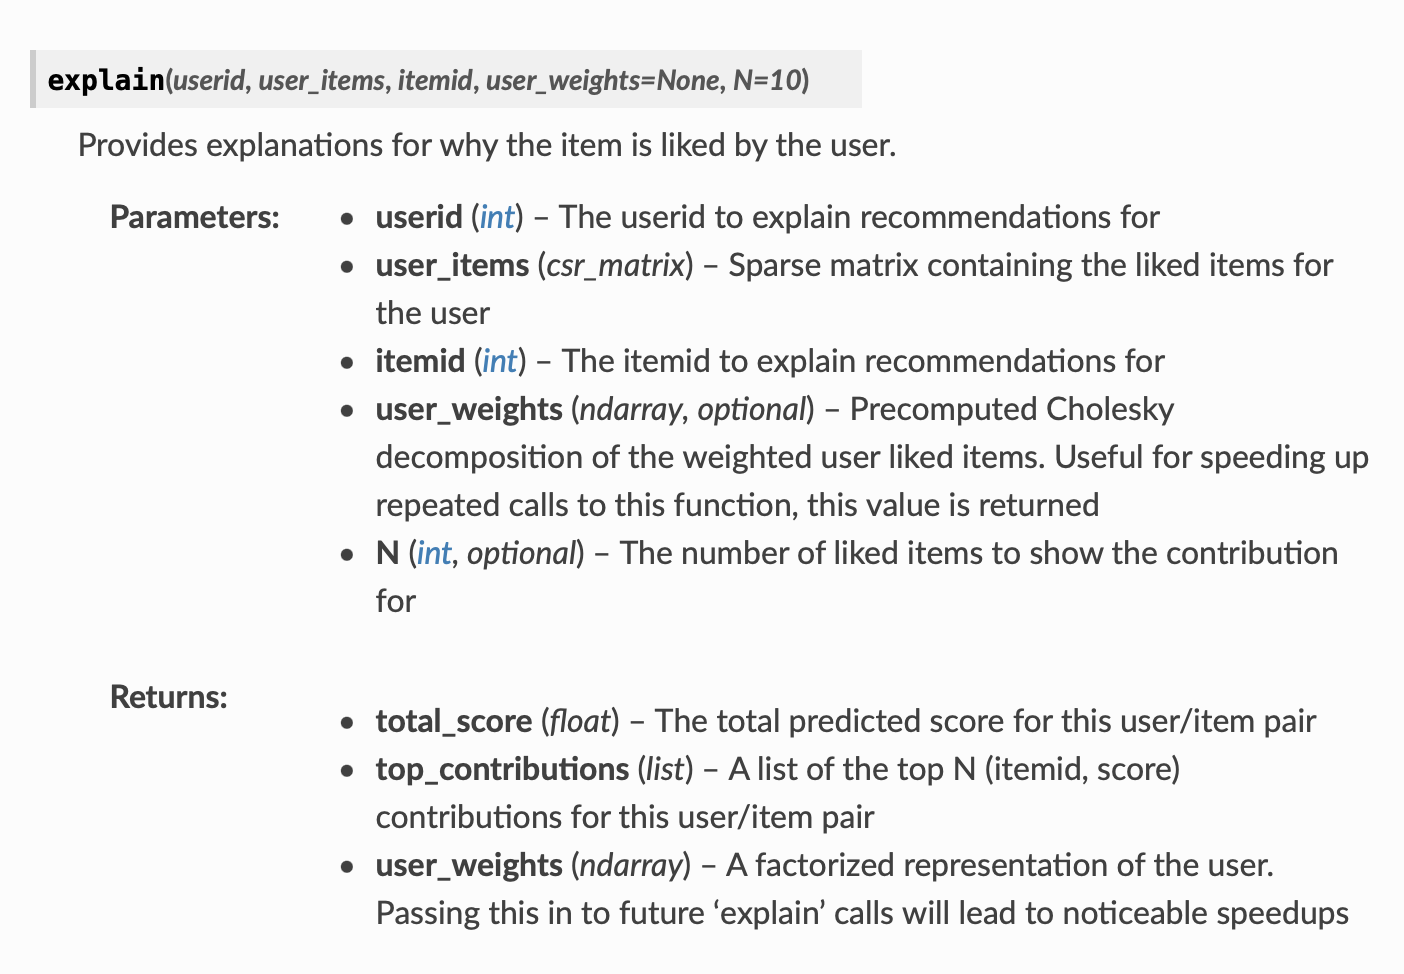


In [42]:
def get_explain(movie_name: str, user_name: str):
    movie_idx = movie_to_idx[movie_name]
    user_idx = user_to_idx[user_name]
    
    explain = als_model.explain(user_idx, csr_data, itemid=movie_idx)
    explain = [(idx_to_movie[idx_val_tuple[0]], idx_val_tuple[1]) for idx_val_tuple in explain[1]]
    return explain

In [43]:
# 확인용
explain = als_model.explain(user_to_idx['nogari'], csr_data, itemid=movie_to_idx['Beauty and the Beast (1991)'])
explain

(0.29461423517325,
 [(350, 0.1944736589776349),
  (568, 0.11349670613236786),
  (342, 0.005571733061788327),
  (1810, 0.002497294411496742),
  (3270, -0.02142515741003782)],
 (array([[ 0.77749003,  0.09336934,  0.08268342, ...,  0.08291483,
           0.08539808,  0.08495998],
         [ 0.07259373,  0.78840575,  0.09842989, ...,  0.07883043,
           0.06791251,  0.07169371],
         [ 0.06428553,  0.08532279,  0.78778037, ...,  0.05871668,
           0.04378133,  0.05417247],
         ...,
         [ 0.06446546,  0.06989207,  0.0608708 , ...,  0.72158691,
           0.00241895,  0.01167417],
         [ 0.06639615,  0.06151618,  0.0482357 , ...,  0.06712144,
           0.71838354, -0.00228689],
         [ 0.06605554,  0.06445639,  0.05675759, ...,  0.08979224,
           0.05781612,  0.71979357]]),
  False))

In [44]:
get_explain('Beauty and the Beast (1991)', 'nogari')

[('Lion King, The (1994)', 0.1944736589776349),
 ('Aladdin (1992)', 0.11349670613236786),
 ('Forrest Gump (1994)', 0.005571733061788327),
 ('Saving Private Ryan (1998)', 0.002497294411496742),
 ('Gladiator (2000)', -0.02142515741003782)]

In [ ]:
Lion King, Aladdin, Forrest Gump, Saving Private Ryan, Gladiator가  Beauty and the Beast, Little Mermaid 등등

# STEP 9. 회고

Matrix Factorization을 사용한 추천 시스템이 었는데 개념 이해가 쉽지 않았다
노드 내용을 따라하면서도 코드 연결과 해석이 쉽지 않아 구현하는데 힘들었다
추천 시스템을 제대로 공부하기 위해서는 책과 병행하면서 공부해야겠다